In [1]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime

In [2]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")


#config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)

In [3]:
#PARAMETERS
TIMEFRAME = "1h"
PAIR = "ETHUSDT"
BLOCK = 512
DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10
FROM_DATE = "2020-10-14 01:00:00" 
TO_DATE = "2022-10-05 01:00:00"
NUM_DATA = 10000 #max 100k
DATA_DIR = "data"
DUMP = 'csv'

path = os.path.join(DATA_DIR, PAIR); print(path)
if not os.path.exists(path):
    os.makedirs(path)

tk1 = os.path.join(PAIR, f'{FROM_DATE.replace(" ", "_").replace(":", "")}_{TIMEFRAME}_{TO_DATE.replace(" ", "_").replace(":", "")}')

path = os.path.join(DATA_DIR, tk1)
if not os.path.exists(path):
    os.makedirs(path)


data\ETHUSDT


In [4]:
class StaticDatabase:
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1500):
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = dateparser.parse(from_date)
        self.to_date = dateparser.parse(to_date)
        self.from_ts = round(datetime.timestamp(self.from_date)*1000)
        self.to_ts = round(datetime.timestamp(self.to_date)*1000)
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.length = len(self.data)
        # self.data = pd.DataFrame()
    
    def get_historical_klines(self):

        # self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit))    
        self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit = self.limit))
        self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
        self.length = len(self.data)
        # print(self.data.iloc[-1]['open_time'])
        # pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms')
        # self.last_ts = round(datetime.timestamp(dateparser.parse(str(self.data.iloc[-1]['open_time'])))*1000)
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
        print(self.to_ts, self.last_ts)
        print(type(self.to_ts), type(self.last_ts))
        print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
                # print(1)
                print(self.data.shape)
                self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['open_time'], unit='ms'))*1000)
                self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))    
                self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
                self.length = len(self.data)
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        return df    



In [5]:
sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)

C:\Users\igor-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [6]:
sdb.get_historical_klines()

1664956800000 1608087600000
<class 'int'> <class 'int'>
True
(3000, 11)
(4500, 11)
(6000, 11)
(7500, 11)
(9000, 11)


<AxesSubplot: >

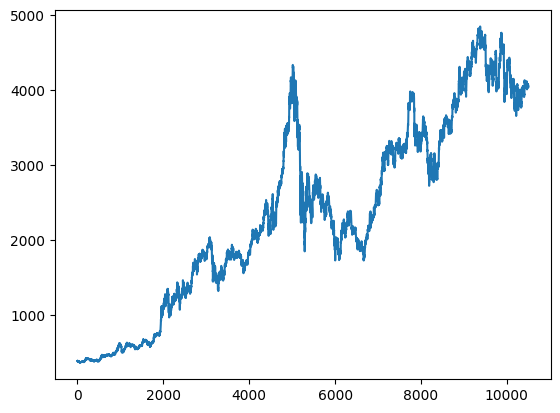

In [7]:
sdb.data.close.plot()

In [8]:
len(sdb.data)

10500

In [9]:
df = sdb.data

In [10]:
if DUMP == 'json':
    sdb.data.to_json(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == 'csv':
    sdb.data.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.csv"))    


In [11]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(2358.9465205417932, 20.356249184792524)

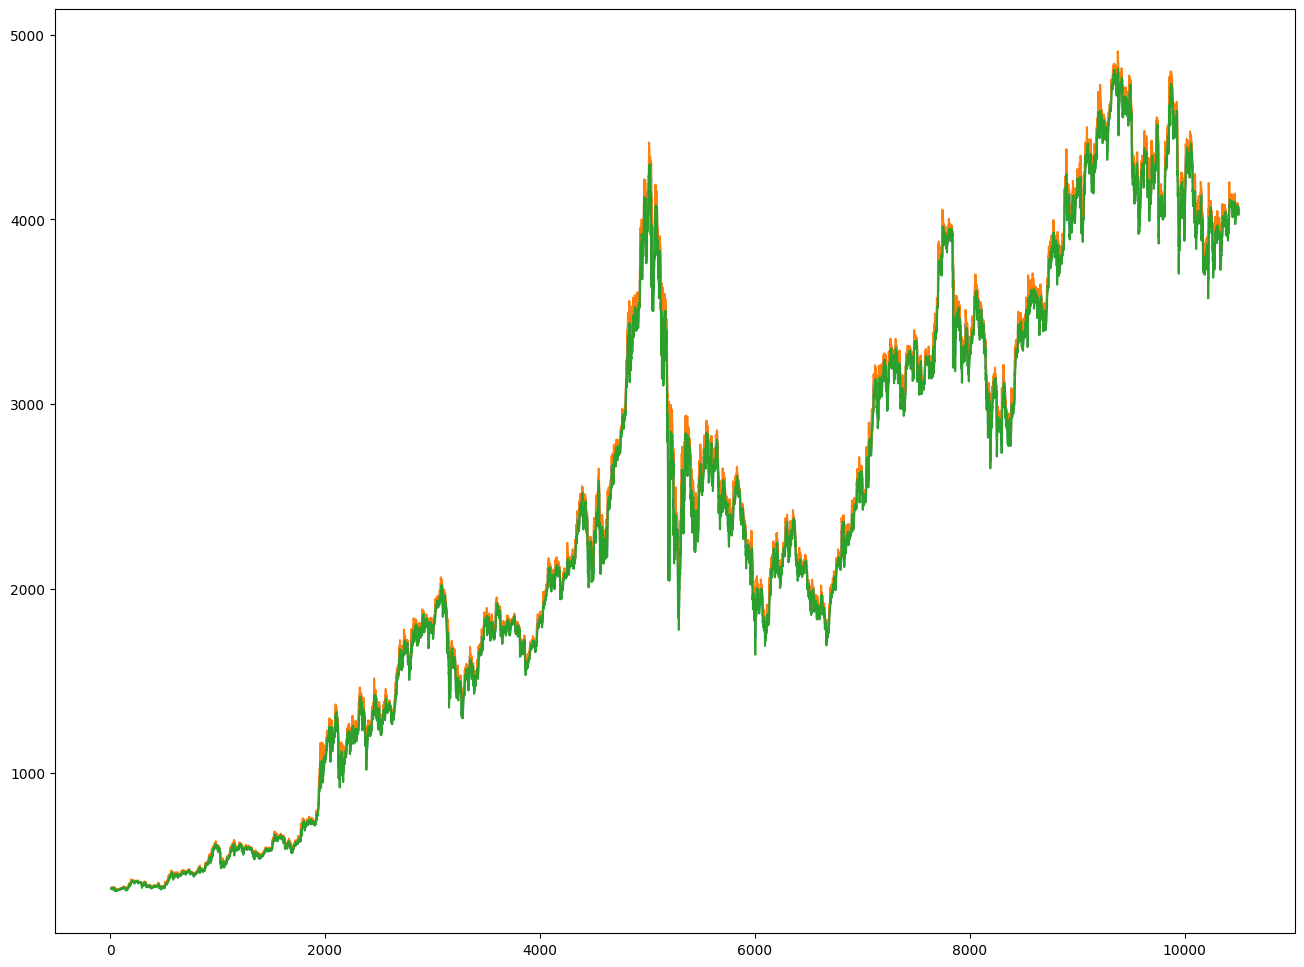

In [12]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [13]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[  202   984  1154  1207  1537  1665  1804  1959  1967  1978  2042  2063
  2076  2104  2110  2130  2152  2162  2212  2219  2224  2256  2261  2286
  2324  2335  2360  2380  2404  2417  2457  2472  2482  2504  2520  2525
  2553  2566  2575  2599  2698  2717  2736  2745  2766  2805  2825  2848
  2879  2916  2942  2980  2988  3047  3080  3087  3108  3143  3155  3161
  3179  3194  3206  3234  3247  3261  3318  3350  3363  3378  3417  3463
  3485  3505  3523  3551  3598  3659  3700  3761  3791  3835  3854  3935
  4005  4081  4101  4120  4154  4171  4200  4254  4304  4339  4352  4357
  4362  4373  4394  4421  4439  4449  4473  4486  4494  4505  4510  4523
  4548  4567  4571  4575  4579  4585  4600  4620  4639  4667  4677  4688
  4697  4712  4730  4774  4804  4814  4819  4825  4832  4839  4845  4854
  4860  4863  4867  4879  4883  4890  4907  4920  4939  4946  4956  4972
  4976  4979  4986  4989  4998  5015  5026  5034  5037  5042  5049  5057
  5061  5075  5083  5085  5096  5105  5109  5115  5

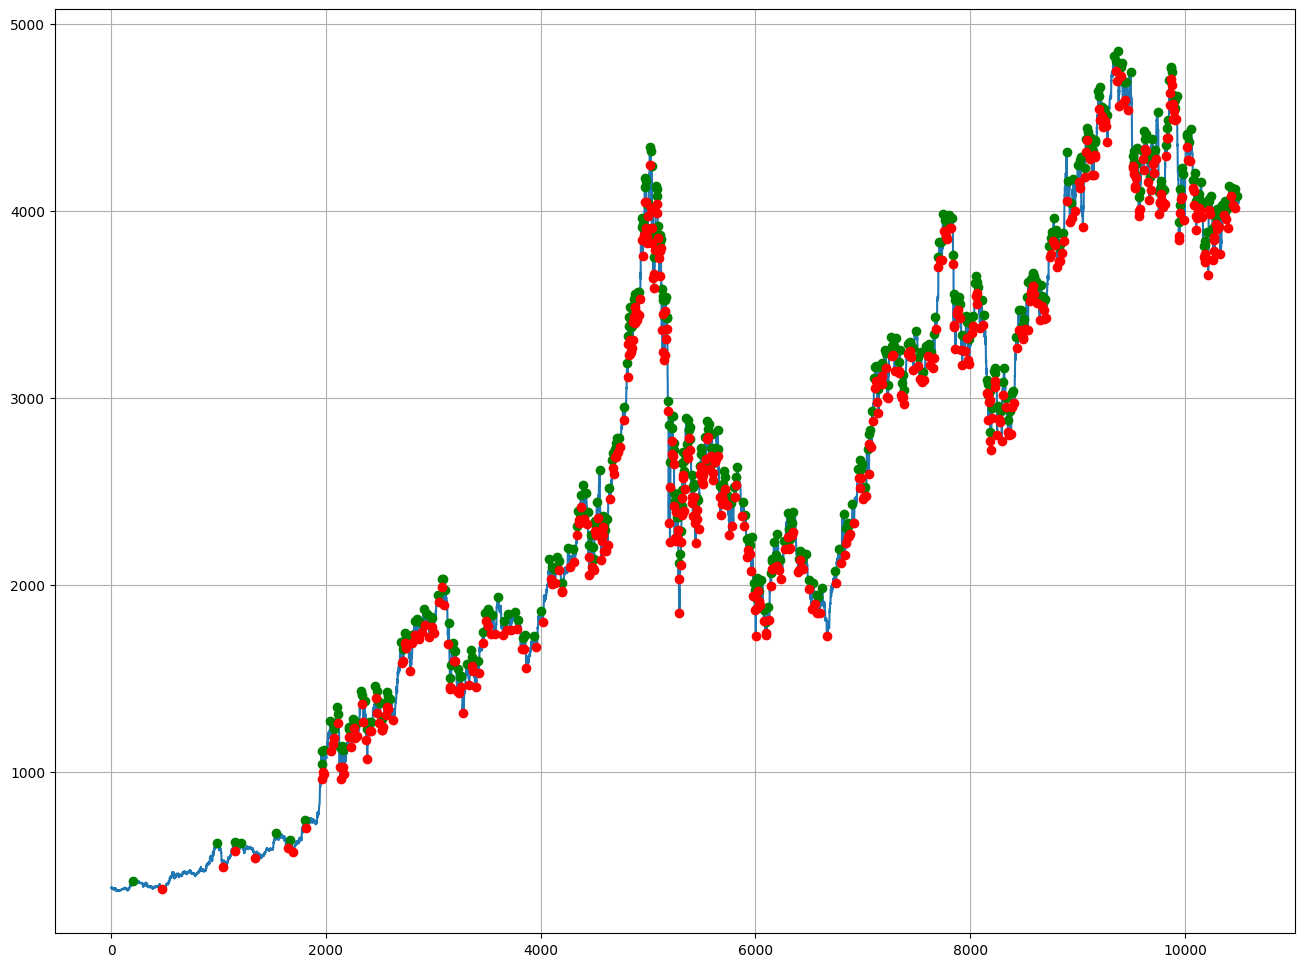

In [14]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [15]:
peak_regions = []
for peak_index in peak_indexes:

    peak_regions.append(peak_index)

    for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

        if peak_index+j >= len(df.close):
            break

        print(peak_index-j, peak_index+j)
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:

            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
    for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

202 202
201 203
200 204
199 205
198 206
984 984
983 985
982 986
981 987
980 988
1154 1154
1153 1155
1152 1156
1151 1157
1150 1158
1207 1207
1206 1208
1205 1209
1204 1210
1203 1211
1537 1537
1536 1538
1535 1539
1534 1540
1533 1541
1665 1665
1664 1666
1663 1667
1662 1668
1661 1669
1804 1804
1803 1805
1802 1806
1801 1807
1800 1808
1959 1959
1958 1960
1957 1961
1956 1962
1955 1963
1967 1967
1966 1968
1965 1969
1964 1970
1963 1971
1978 1978
1977 1979
1976 1980
1975 1981
1974 1982
2042 2042
2041 2043
2040 2044
2039 2045
2038 2046
2063 2063
2062 2064
2061 2065
2060 2066
2059 2067
2076 2076
2075 2077
2074 2078
2073 2079
2072 2080
2104 2104
2103 2105
2102 2106
2101 2107
2100 2108
2110 2110
2109 2111
2108 2112
2107 2113
2106 2114
2130 2130
2129 2131
2128 2132
2127 2133
2126 2134
2152 2152
2151 2153
2150 2154
2149 2155
2148 2156
2162 2162
2161 2163
2160 2164
2159 2165
2158 2166
2212 2212
2211 2213
2210 2214
2209 2215
2208 2216
2219 2219
2218 2220
2217 2221
2216 2222
2215 2223
2224 2224
2223 2225


In [16]:
len(peak_regions) - len(peak_indexes)

729

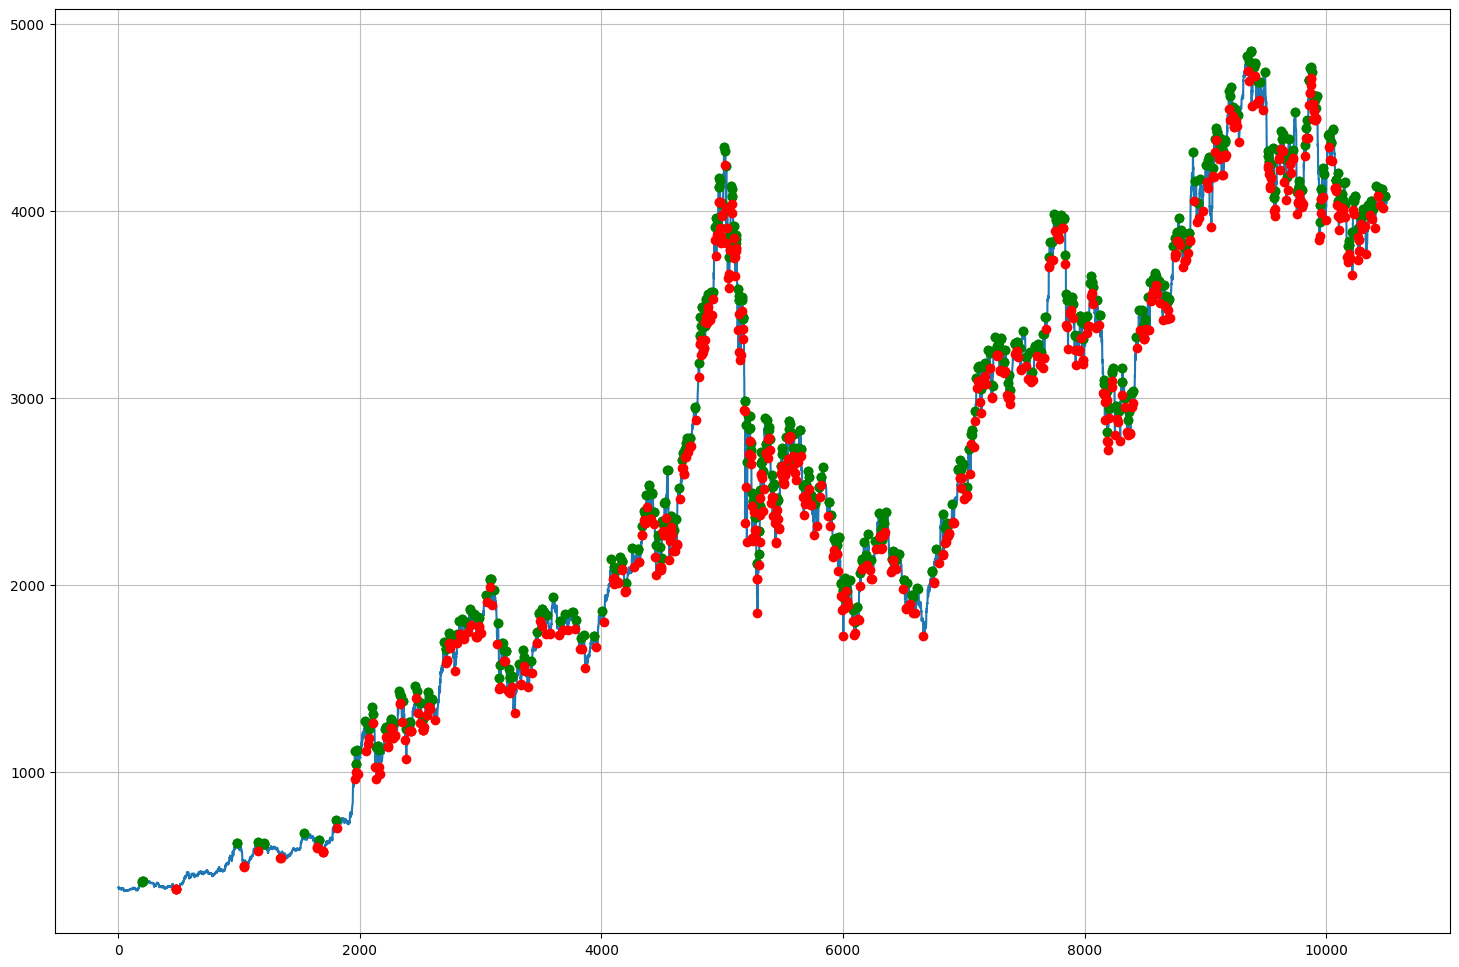

In [17]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


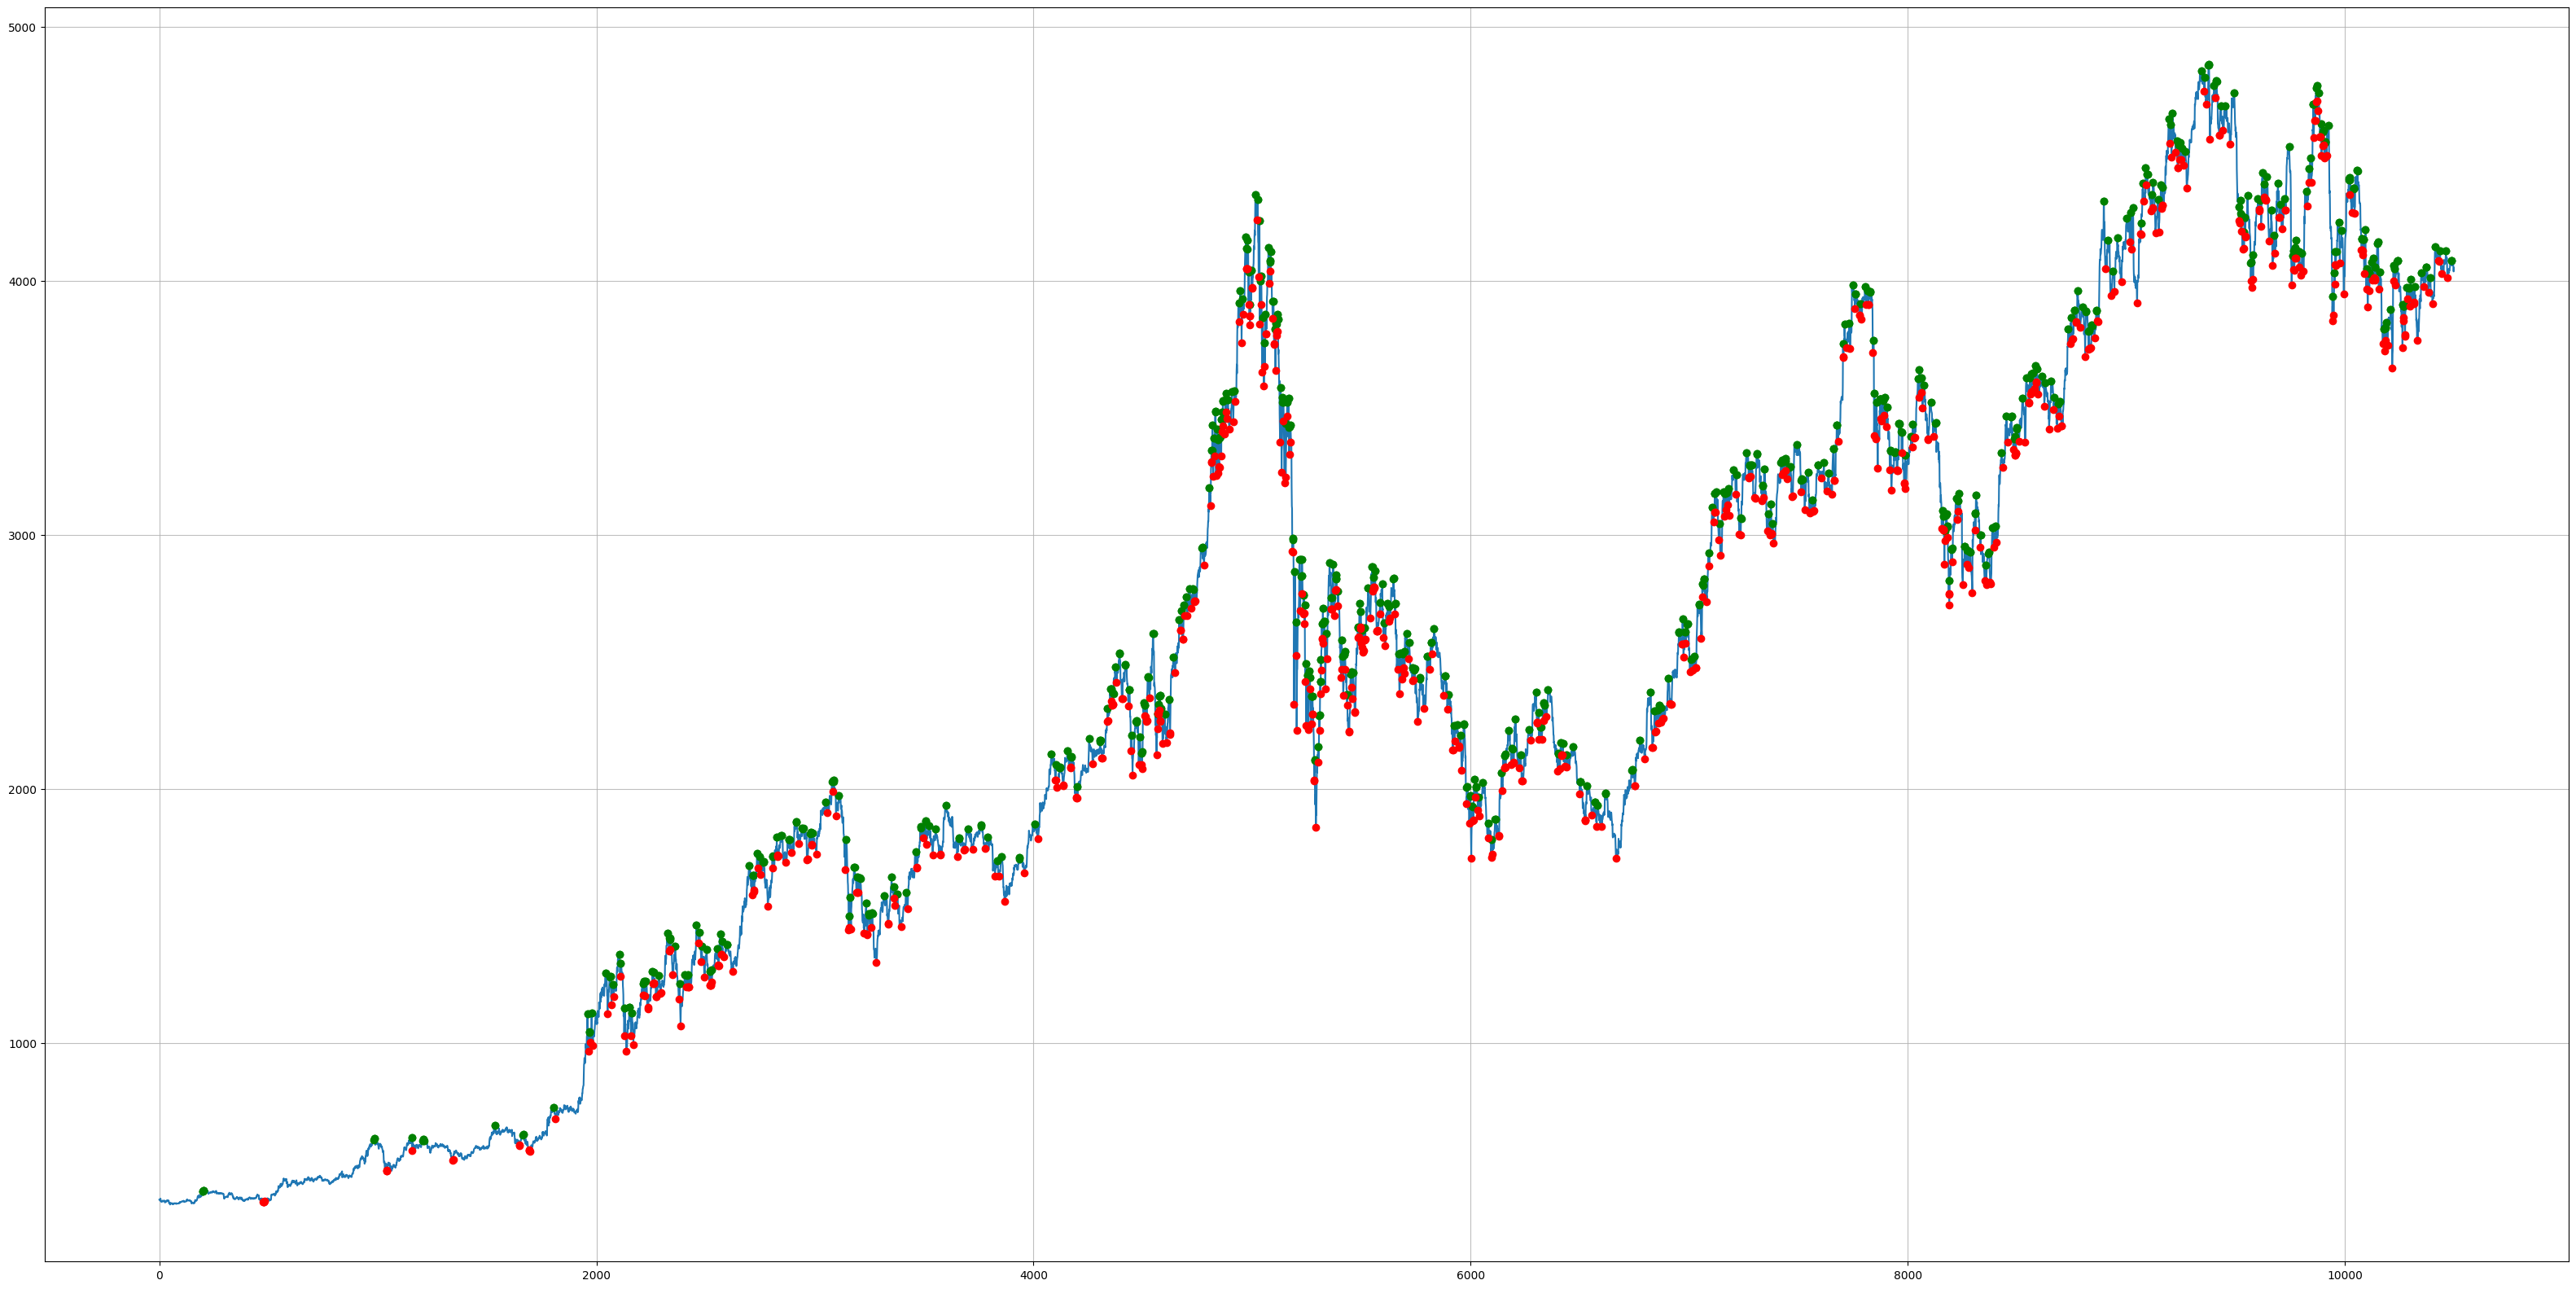

In [18]:
df = sdb.data
(fig, ax) = plt.subplots(figsize=(40,20))
ax.plot(df.close)
peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [19]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
labels = pd.DataFrame(labels, columns=['labels'])
df = pd.concat([df, labels], axis=1)
print(labels[labels!=0].dropna())
    

       labels
198       1.0
199       1.0
200       1.0
201       1.0
202       1.0
...       ...
10444    -1.0
10463     1.0
10469    -1.0
10487     1.0
10488     1.0

[1390 rows x 1 columns]


In [20]:
df


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,labels
0,2020-10-14 08:00:00,382.43,383.25,381.58,382.73,34362.479,2020-10-14 08:59:59.999,1.314822e+07,17090,15622.179,5.978413e+06,0
1,2020-10-14 09:00:00,382.73,383.27,381.10,381.57,29966.866,2020-10-14 09:59:59.999,1.145020e+07,17639,12200.015,4.662574e+06,0
2,2020-10-14 10:00:00,381.59,381.99,377.63,379.38,96644.158,2020-10-14 10:59:59.999,3.669329e+07,27813,37611.495,1.428429e+07,0
3,2020-10-14 11:00:00,379.37,381.20,378.89,378.95,44749.488,2020-10-14 11:59:59.999,1.701112e+07,19569,21392.743,8.135165e+06,0
4,2020-10-14 12:00:00,378.95,381.92,378.30,381.63,50001.994,2020-10-14 12:59:59.999,1.902408e+07,20727,28193.448,1.073072e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10495,2021-12-27 05:00:00,4068.44,4069.20,4060.26,4062.18,13872.030,2021-12-27 05:59:59.999,5.638794e+07,32039,6756.318,2.746735e+07,0
10496,2021-12-27 06:00:00,4062.17,4071.60,4056.23,4068.75,19501.651,2021-12-27 06:59:59.999,7.925157e+07,33648,9493.764,3.858511e+07,0
10497,2021-12-27 07:00:00,4068.75,4070.56,4048.00,4051.16,25900.088,2021-12-27 07:59:59.999,1.050758e+08,45188,11356.159,4.607541e+07,0
10498,2021-12-27 08:00:00,4051.16,4063.14,4033.00,4037.40,35978.878,2021-12-27 08:59:59.999,1.457055e+08,65196,15837.097,6.416142e+07,0


In [21]:
if DUMP == 'json':
    df.to_json(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}.json"))
elif DUMP == 'csv':
    df.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}_features.csv"))    
    labels.to_csv(os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

In [22]:
data_path = os.path.join(DATA_DIR, tk1, f"{PAIR}_{TIMEFRAME}")
print(data_path)       
labels = pd.read_csv(data_path + "_labels.csv")
labels.drop(['Unnamed: 0'], axis=1, inplace=True)
features = pd.read_csv(data_path + "_features.csv")
features.drop(['Unnamed: 0'], axis=1, inplace=True)
print(labels)
print(features)

data\ETHUSDT\2020-10-14_010000_1h_2022-10-05_010000\ETHUSDT_1h
       labels
0           0
1           0
2           0
3           0
4           0
...       ...
10495       0
10496       0
10497       0
10498       0
10499       0

[10500 rows x 1 columns]
                 open_time     open     high      low    close     volume  \
0      2020-10-14 08:00:00   382.43   383.25   381.58   382.73  34362.479   
1      2020-10-14 09:00:00   382.73   383.27   381.10   381.57  29966.866   
2      2020-10-14 10:00:00   381.59   381.99   377.63   379.38  96644.158   
3      2020-10-14 11:00:00   379.37   381.20   378.89   378.95  44749.488   
4      2020-10-14 12:00:00   378.95   381.92   378.30   381.63  50001.994   
...                    ...      ...      ...      ...      ...        ...   
10495  2021-12-27 05:00:00  4068.44  4069.20  4060.26  4062.18  13872.030   
10496  2021-12-27 06:00:00  4062.17  4071.60  4056.23  4068.75  19501.651   
10497  2021-12-27 07:00:00  4068.75  4070.56  4048

In [23]:
sdb.data = df
features =sdb.data

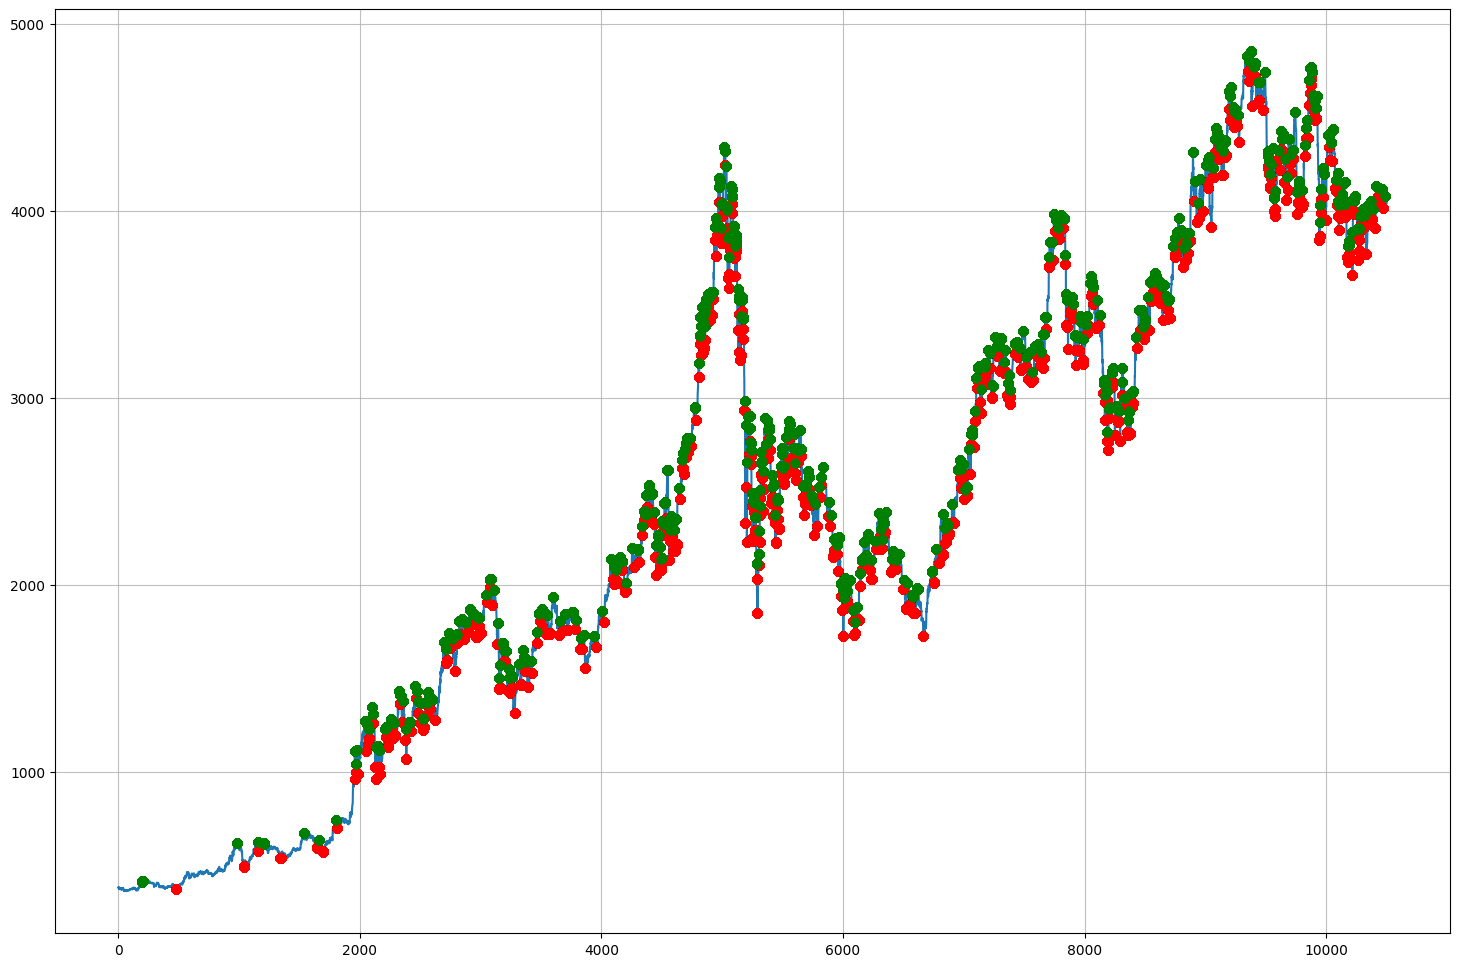

In [24]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(features.close)
none = []
for i, l in enumerate(features.labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = features.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = features.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
# ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.01, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [25]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):

        # any additional label treatment
        self.labels = pd.read_csv(data_path + "_labels.csv")
        self.labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        
        #feature engineering
        self.features = pd.read_csv(data_path + "_features.csv")
        self.features.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.features.drop(['close_time'], axis=1, inplace=True)
        self.features.drop(['labels'], axis=1, inplace=True)
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

C:\Users\igor-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
ds = CustomDataset(data_path)


In [27]:
from torch.utils.data import DataLoader

dataloader = DataLoader(ds, batch_size=64, shuffle=True)


In [28]:
ds.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06


In [29]:
ds.labels

,labels
0,0
1,0
2,-1
3,1
4,-1
...,...
10495,0
10496,0
10497,0
10498,0


In [30]:
dataloader.dataset.features

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume
0,2019-11-27 07:45:00,146.00,146.00,146.00,146.00,0.010,1.460000e+00,1,0.000,0.000000e+00
1,2019-11-27 08:00:00,146.00,146.00,146.00,146.00,0.000,0.000000e+00,0,0.000,0.000000e+00
2,2019-11-27 08:15:00,125.03,125.03,125.03,125.03,0.010,1.250300e+00,1,0.000,0.000000e+00
3,2019-11-27 08:30:00,145.00,145.00,145.00,145.00,0.020,2.900000e+00,2,0.000,0.000000e+00
4,2019-11-27 08:45:00,145.01,145.01,133.00,133.00,0.050,6.770100e+00,2,0.010,1.450100e+00
...,...,...,...,...,...,...,...,...,...,...
10495,2020-03-17 14:00:00,113.09,114.91,112.51,113.82,35557.698,4.046765e+06,7112,18061.825,2.055813e+06
10496,2020-03-17 14:15:00,113.79,115.50,113.55,115.29,25336.127,2.901673e+06,5690,14325.847,1.641335e+06
10497,2020-03-17 14:30:00,115.28,115.68,114.04,115.40,34254.968,3.937871e+06,5930,17229.602,1.981916e+06
10498,2020-03-17 14:45:00,115.40,115.68,114.77,115.39,19647.917,2.263713e+06,3767,11837.663,1.364054e+06
